## Notebook 2: Model Training & Evaluation

In this notebook, I use the cleaned dataset from Notebook 1 to build and evaluate a machine learning model that predicts whether a song is popular.

By the end of this notebook, I will have a fully trained model and all the files needed to run predictions in the interactive app.

### Load in the cleansed data set

In [2]:
import pandas as pd

#Load in the cleansed dataset
df = pd.read_csv("../data/spotify_cleaned.csv")

df.head()

,main_artist,artist_mainstream_level,track_name,is_popular,popularity,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artist_monthly_listeners
0,Gen Hoshino,0,Comedy,1,73,230666,False,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,NaN
1,Ben Woodward,0,Ghost - Acoustic,1,55,149610,False,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,NaN
2,ZAYN,1,To Begin Again,1,57,210826,False,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,24323031.0
3,Kina Grannis,0,Can't Help Falling In Love,1,71,201933,False,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,NaN
4,Chord Overstreet,0,Hold On,1,82,198853,False,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,5202733.0


### Defining the Features (X) and Target (y)

In this step, I set up the inputs and output for the model. The target variable is is_popular, which indicates whether a song is in the top 25% of popularity.

The model will use the following types of features:

 - **Numerical Features**: duration_ms, explicit, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, artist_monthly_listeners
 
 - **Categorical Features**: artist_mainstream_level, track_genre

It is important that we exclude the original popularity score when training the model because we are trying to predict popularity. Including it would cause target leakage, giving the model access to the answer and making the evaluation invalid.

In [3]:
# Target
y = df["is_popular"]

# Features to use for prediction
feature_cols = [
    "duration_ms",
    "explicit",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
    "artist_monthly_listeners",
    "artist_mainstream_level",
    "track_genre"
]

X = df[feature_cols]

X.head()

,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_monthly_listeners,artist_mainstream_level,track_genre
0,230666,False,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,NaN,0,acoustic
1,149610,False,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,NaN,0,acoustic
2,210826,False,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,24323031.0,1,acoustic
3,201933,False,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,NaN,0,acoustic
4,198853,False,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,5202733.0,0,acoustic


### One-Hot Encoding the Categorical Features

Logistic Regression requires all inputs to be numeric, so before training the model we convert our categorical columns into dummy variables. This process creates separate binary columns for each category.

Even though artist_mainstream_level is stored as numbers (0, 1, 2), these still values represent categories, not meaningful numerical magnitudes (e.g., level 2 is not twice level 1). Because of this, it also needs to be one-hot encoded.

Using pd.get_dummies(), both artist_mainstream_level and track_genre are expanded into binary indicator columns. Setting drop_first=True avoids multicollinearity by removing one redundant category per feature.

In [4]:
# Convert categorical variables to one-hot encoding
X_encoded = pd.get_dummies(
    X,
    columns=["artist_mainstream_level", "track_genre"],
    drop_first=True  # avoids multicollinearity
)

X_encoded.head()


,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,230666,False,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,...,False,False,False,False,False,False,False,False,False,False
1,149610,False,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,...,False,False,False,False,False,False,False,False,False,False
2,210826,False,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,...,False,False,False,False,False,False,False,False,False,False
3,201933,False,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,...,False,False,False,False,False,False,False,False,False,False
4,198853,False,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,...,False,False,False,False,False,False,False,False,False,False


### Checking for NaN values
Before we train our model, lets make sure there are no NaN values in our dataset

In [5]:
# Check for missing values in the encoded feature matrix
X_encoded.isna().sum().sort_values(ascending=False).head(20)


artist_monthly_listeners      81845
duration_ms                       0
track_genre_latin                 0
track_genre_pop                   0
track_genre_piano                 0
track_genre_party                 0
track_genre_pagode                0
track_genre_opera                 0
track_genre_new-age               0
track_genre_mpb                   0
track_genre_minimal-techno        0
track_genre_metalcore             0
track_genre_metal                 0
track_genre_mandopop              0
track_genre_malay                 0
track_genre_latino                0
track_genre_kids                  0
track_genre_power-pop             0
track_genre_k-pop                 0
track_genre_jazz                  0
dtype: int64

As we can see, there are many NaN values in the artist_monthly_listeners column, likely due to the fact that these artists did not appear in the df_artists dataset when we merged them. To fix this, I will replace the NaN values with the median listener count. Then I will recreate the encoded matrix. 

In [6]:
# Fill missing artist listener values with the median
median_listeners = df["artist_monthly_listeners"].median()

df["artist_monthly_listeners"] = df["artist_monthly_listeners"].fillna(median_listeners)

# Rebuild X since df changed
X = df[feature_cols]

# Re-encode after filling NaN
X_encoded = pd.get_dummies(
    X,
    columns=["artist_mainstream_level", "track_genre"],
    drop_first=True
)

# Confirm no NaNs remain
X_encoded.isna().sum().sum()


np.int64(0)

### Train–Test Split

Before training the model, we split the data into a training set (80%) and a test set (20%). The model will learn from the training data and then be evaluated on the test data to see how well it generalizes to unseen examples.

I use stratify=y to ensure that the proportion of popular vs. non-popular songs stays consistent in both sets, which is important because the dataset is already imbalanced.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,      # the encoded feature matrix
    y,              # target variable
    test_size=0.2,  # 20% test
    random_state=42, # ensures reproducibility
    stratify=y       # keeps the same popularity ratio in train/test
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((91199, 128), (22800, 128), (91199,), (22800,))

### Feature Scaling (Standardization)

To help the Logistic Regression model train effectively, we must scale all numerical features so they are on a similar range. Without scaling, features with larger numeric values could dominate the model and lead to slower convergence or worse performance.

To do this, I will be using StandardScaler (Z-score normalization): scaled_value = (x - mean) / std This ensures that all numeric features will have a mean = 0 and standard deviation = 1.

It is very important to fit the scaler only on the training data and then apply it to both the training and test sets. This prevents data leakage and makes sure the information from the test set does not influence the model during training.

In [8]:
from sklearn.preprocessing import StandardScaler

# Create scaler
scaler = StandardScaler()

# Fit ONLY on training data, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((91199, 128), (22800, 128))

### Training A Logistic Regression Model

Now that our data is ready, we can train a Logistic Regression classifier. This model is a good fit for binary classification problems like predicting whether a song is popular (is_popular = 0 or 1).

 - Input: X_train_scaled (scaled features), y_train (target labels)
 - Output: a trained logistic regression model that can make predictions on new songs

I increased max_iter to 1000 to ensure the model has enough iterations to converge, and used the default lbfgs solver, which works well for this type of problem.

In [9]:
from sklearn.linear_model import LogisticRegression

# Create the model
log_reg = LogisticRegression(
    max_iter=1000,      # allow enough iterations to converge
    solver="lbfgs"      # good default solver
)

# Train (fit) the model on the training data
log_reg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Generating Predictions

Our model is trained! We can now evaluate how well it performs on unseen data. The first step is to generate predictions using the test set.

 - y_pred contains the model’s binary predictions (0 = not popular, 1 = popular)
 - y_pred_proba contains the predicted probability that each song is popular, which will be useful later when we compute ROC & AUC

In [10]:
# Predict on the test set
y_pred = log_reg.predict(X_test_scaled)

# Also get prediction probabilities (for ROC later)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix

# How many songs are predicted popular in the test set?
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))


{np.int64(0): np.int64(19398), np.int64(1): np.int64(3402)}

### Accuracy Score

To get a quick sense of how well the model performs, I calculate the accuracy score, which measures the percentage of test samples the model classified correctly.

In [12]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7838157894736842

As we can see, the model achieved 78% accuracy on the test set, demonstrating strong predictive capability given the simplicity of the input features. Since Spotify popularity is quite noisy and can be influenced by many external factors (such as company label, social media, marketing), acheiving this accuracy with just audio + artist metadata is very good.

### Confusion Matirx

This will show us how many true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) the model predicted.

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm


array([[15698,  1229],
       [ 3700,  2173]])

To visualize the matrix:

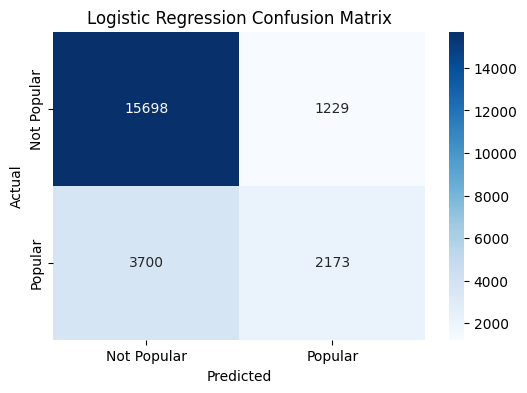

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Popular", "Popular"],
            yticklabels=["Not Popular", "Popular"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


#### Interpetting the Confusion Matrix:
 - True Negative Rate is 93% → the model is good at identifying songs that are not popular.
 - False Negative Rate is high → the model struggles to identify some popular songs.
 - This is expected since predicting “hits” is much harder than predicting non-hits, especially when they deviate from features that may make other songs popular. 

From this, we can conclude that the model is more conservative and tends to under-predict popularity, favoring precision on the negative class. This reflects the difficulty in identifying songs that become truly popular.

### Precision, Recall, and F1 Scores

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.93      0.86     16927
           1       0.64      0.37      0.47      5873

    accuracy                           0.78     22800
   macro avg       0.72      0.65      0.67     22800
weighted avg       0.77      0.78      0.76     22800



#### Interpretation

For class 0 (not popular):
 - Precision: 0.81 → 81% of predicted “not popular” songs were correct
 - Recall: 0.93 → 93% of actual “not popular” songs were correctly identified
 - F1: 0.86

This is looks great!

For class 1 (popular):
 - Precision: 0.64 → moderately good
 - Recall: 0.37 → the model only catches ~37% of all actual popular songs
 - F1: 0.47

This shows to be not as accurate, but it is expected. 

The model showed strong performance on the majority class (not popular), with an F1-score of 0.86. Performance on the minority class (popular) was lower (F1-score 0.47), which is expected due to class imbalance and the intrinsic difficulty in predicting hit songs.

### ROC and AUC

The ROC (Receiver Operating Characteristic) curve evaluates how well the model differentiates between popular and non-popular songs across all possible probability thresholds. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR), allowing us to visualize the trade-off between correctly identifying popular songs and avoiding false alarms.

The AUC (Area Under the ROC Curve) summarizes the ROC curve into a single score between 0 and 1. An AUC of 0.5 represents random guessing, while values between 0.8 and 0.9 indicate strong predictive performance.

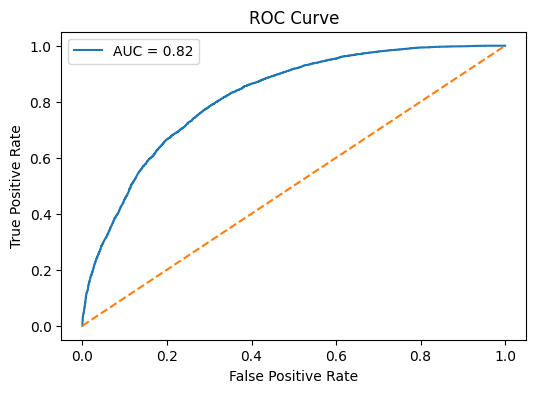

In [16]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


This model achieved an AUC of 0.82, which means it is able to correctly differentiate between popular and non-popular songs about 82% of the time. Demonstrates strong discriminative ability despite the complexity of predicting real-world music popularity.

### Random Forest Model and Performance Comparison

After training the Logistic Regression model, I also trained a Random Forest Classifier to see whether a nonlinear model could capture more complex patterns in the data. Random Forests often perform better when the relationship between features and the target is not purely linear and when there are many categorical dummy variables — both of which apply to this dataset.

The Random Forest was trained on the same training data (scaled), and I generated predictions and evaluation metrics in the same way as before.

Random Forest Evaluation
-------------------------
Accuracy: 0.8619
AUC: 0.9129

Precision / Recall / F1:
  Class 0 (Not Popular): precision=0.87, recall=0.95, f1=0.91
  Class 1 (Popular):     precision=0.82, recall=0.60, f1=0.69

Confusion Matrix:
[[16141   786]
 [ 2363  3510]]


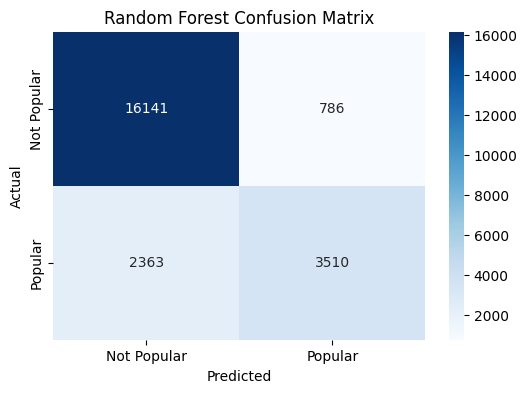

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Train Random Forest Model
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

# -----------------------------
# Predictions
# -----------------------------
rf_pred = rf.predict(X_test_scaled)
rf_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

# -----------------------------
# Metrics
# -----------------------------
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)
rf_cm = confusion_matrix(y_test, rf_pred)

rf_precision_0 = precision_score(y_test, rf_pred, pos_label=0)
rf_recall_0 = recall_score(y_test, rf_pred, pos_label=0)
rf_f1_0 = f1_score(y_test, rf_pred, pos_label=0)

rf_precision_1 = precision_score(y_test, rf_pred, pos_label=1)
rf_recall_1 = recall_score(y_test, rf_pred, pos_label=1)
rf_f1_1 = f1_score(y_test, rf_pred, pos_label=1)

# -----------------------------
# Print Metrics Cleanly
# -----------------------------
print("Random Forest Evaluation")
print("-------------------------")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"AUC: {rf_auc:.4f}")
print("\nPrecision / Recall / F1:")
print(f"  Class 0 (Not Popular): precision={rf_precision_0:.2f}, recall={rf_recall_0:.2f}, f1={rf_f1_0:.2f}")
print(f"  Class 1 (Popular):     precision={rf_precision_1:.2f}, recall={rf_recall_1:.2f}, f1={rf_f1_1:.2f}")
print("\nConfusion Matrix:")
print(rf_cm)

# -----------------------------
# Confusion Matrix Visualization
# -----------------------------
plt.figure(figsize=(6,4))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Popular", "Popular"],
            yticklabels=["Not Popular", "Popular"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The results show a significant improvement compared to Logistic Regression:
 - Accuracy improved from ~78% to ~86%
 - AUC increased from ~0.82 to ~0.91
 - The model made far fewer false negatives, meaning it is much better at correctly identifying popular songs
 - Precision and recall for the popular class improved noticeably, confirming that Random Forest handles class imbalance and nonlinear effects more effectively

Overall, the Random Forest model provides stronger predictive performance across all key metrics. This suggests that song popularity is influenced by nonlinear interactions between audio features, artist exposure, and genre.

Because of this improvement, Random Forest is the preferred model for making predictions in the Streamlit app.

### Saving the Model and Preprocessing Artifacts

To use this model later in the Streamlit app, I need to save all of the components required to reproduce the full prediction pipeline. This includes:

 - The trained logistic regression model
 - The trained Random Forest Classifier
 - The fitted StandardScaler, so new user inputs can be scaled the same way
 - The exact list of encoded feature columns, which ensures the app builds the input vector in the same format as training

These objects are saved into the models/ folder using joblib. The saved files will be loaded directly into streamlit_app.py when running the prediction widget.

In [18]:
import os
from joblib import dump

# Make sure the models directory exists
os.makedirs("../models", exist_ok=True)

#still save the logistic regression model
dump(log_reg, "../models/log_reg_spotify.pkl")

# 1) Save the trained Random Forest model
dump(rf, "../models/rf_spotify.pkl") 

# 2) Save the fitted scaler (same as before)
dump(scaler, "../models/scaler.pkl")

# 3) Save the list of feature column names used during training (same as before)
feature_cols_full = X_encoded.columns.tolist()
dump(feature_cols_full, "../models/feature_columns.pkl")

feature_cols_full[:10], len(feature_cols_full)

(['duration_ms',
  'explicit',
  'danceability',
  'energy',
  'loudness',
  'speechiness',
  'acousticness',
  'instrumentalness',
  'liveness',
  'valence'],
 128)